In [1]:
import numpy as np 
import pandas as pd 
import pickle

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import xgboost
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [24]:
with open('./data/closed_listings_cleaned.pickle', 'rb') as read_file:
    df = pickle.load(read_file)
df.head()

,property_id,listing_id,status,list_date,list_price,description.sold_price,description.year_built,description.baths_3qtr,description.sold_date,description.baths_full,...,description.beds,location.address.postal_code,location.address.state,location.address.coordinate.lon,location.address.coordinate.lat,location.address.city,location.address.state_code,location.address.line,location.county.fips_code,location.county.name
0,2507173757,2930532060,sold,2021-06-15T15:05:55Z,1549000.0,1760000,1926,NaN,2021-07-16,2.0,...,3.0,90026,California,-118.276835,34.085110,Los Angeles,CA,3380 Descanso Dr,06037,Los Angeles
1,1681184474,2927976112,sold,2021-04-09T21:02:06Z,879000.0,850000,2008,NaN,2021-07-16,1.0,...,1.0,90015,California,-118.263194,34.040804,Los Angeles,CA,1155 S Grand Ave Apt 1807,06037,Los Angeles
2,2913082626,2930168949,sold,2021-06-05T00:02:43Z,849000.0,1016000,1912,NaN,2021-07-16,2.0,...,2.0,90018,California,-118.314134,34.023169,Los Angeles,CA,3563 S Gramercy Pl,06037,Los Angeles
3,1415870805,2931114156,sold,2021-06-29T16:08:40Z,1499000.0,1625000,1900,NaN,2021-07-16,3.0,...,5.0,90026,California,-118.267025,34.079045,Los Angeles,CA,1107 Waterloo St,06037,Los Angeles
4,2820635269,2929515091,sold,2021-05-20T16:00:15Z,395000.0,385000,1985,NaN,2021-07-16,1.0,...,2.0,90044,California,-118.295523,33.930572,Los Angeles,CA,11401 Berendo Ave Apt 6,06037,Los Angeles


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72662 entries, 0 to 243197
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_id                      72662 non-null  object 
 1   listing_id                       72662 non-null  object 
 2   status                           72662 non-null  object 
 3   list_date                        72661 non-null  object 
 4   list_price                       72662 non-null  float64
 5   description.sold_price           72662 non-null  int64  
 6   description.year_built           72662 non-null  int64  
 7   description.baths_3qtr           3825 non-null   float64
 8   description.sold_date            72662 non-null  object 
 9   description.baths_full           71011 non-null  float64
 10  description.baths_half           19044 non-null  float64
 11  description.lot_sqft             66486 non-null  float64
 12  description.sqft 

In [26]:
df['price_change'] = 100*(df['description.sold_price'] - df['list_price'])/df['list_price']

In [27]:
df = df[df['price_change'] <= 100]

In [28]:
df = df[df['description.type'] != 'farm']

In [29]:
df = df[df['description.sqft'] <= 5000]

In [45]:
df = df[df['description.lot_sqft'] < 100000]

In [66]:
df = df[df['description.sold_price'] <  10000000 ] 

In [68]:
#randomly sample 20% data and create a pairplot
sample_df = df.sample(n = 1000, replace = False)

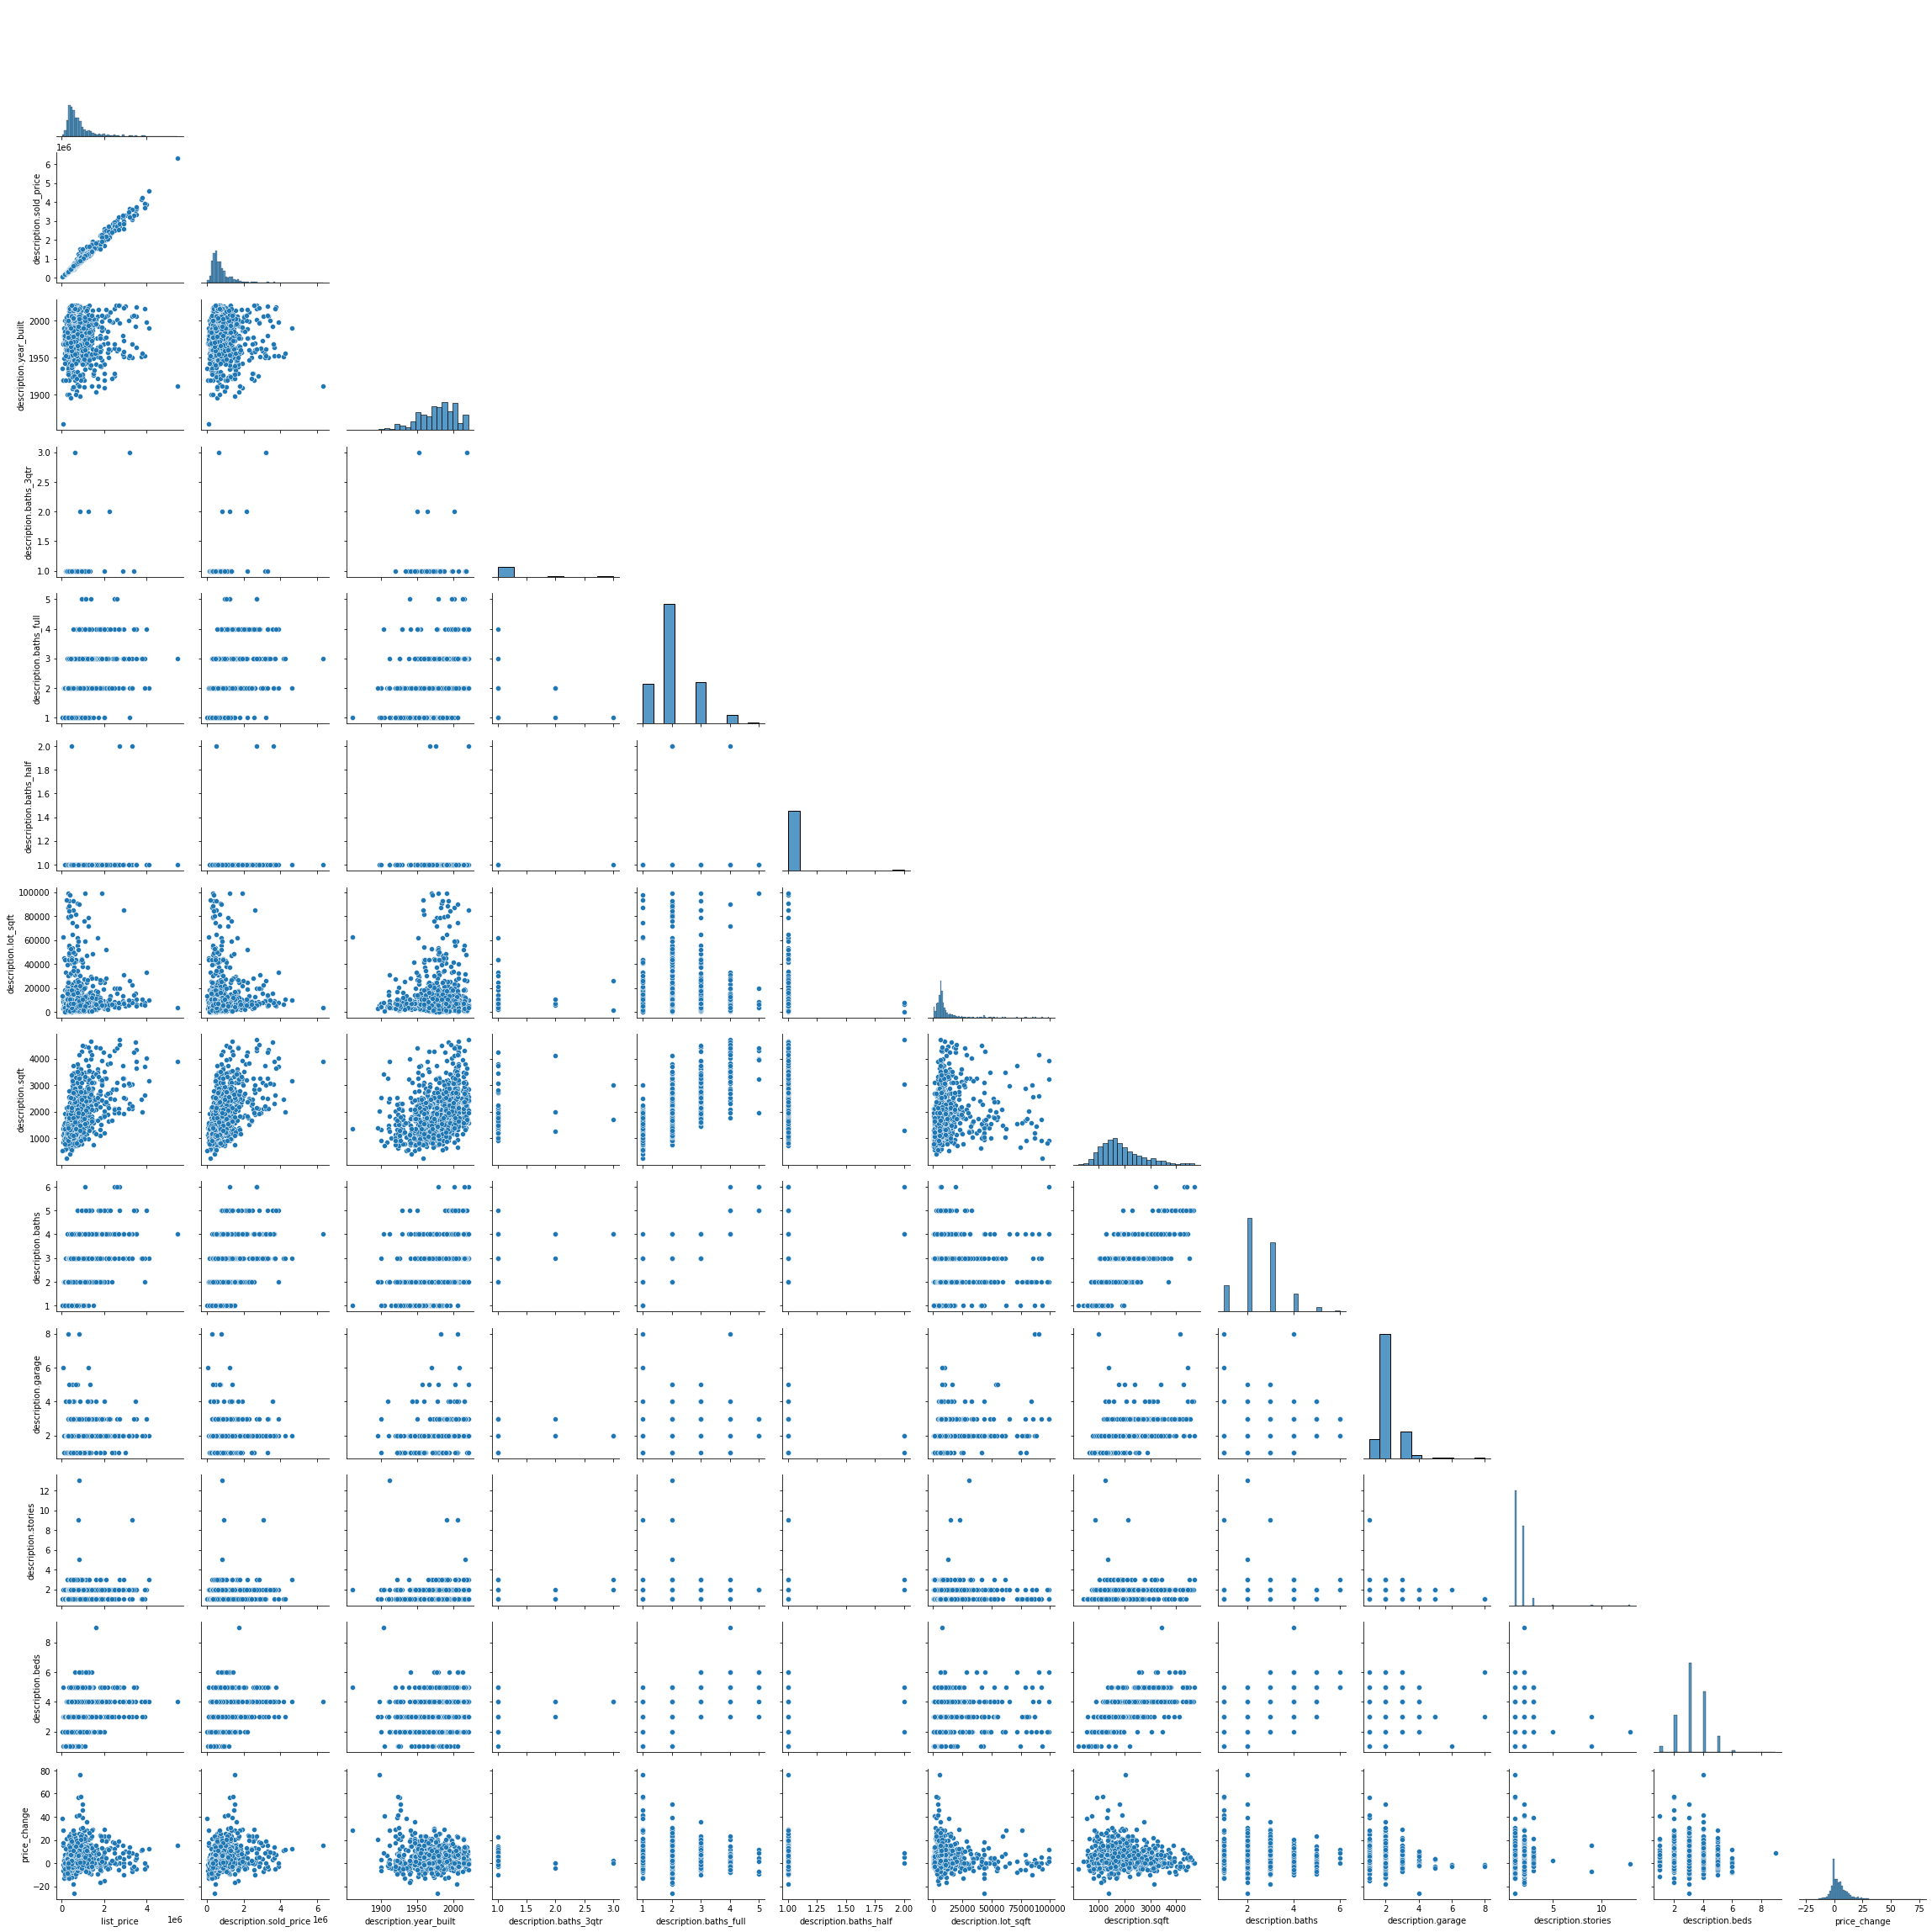

In [69]:
sns.pairplot(sample_df, corner=True)

In [50]:
#Remove lan, lon, state and address columns
df.drop(columns = ['location.address.coordinate.lon','location.address.coordinate.lat','location.address.state','location.address.state_code', 'location.address.line','description.sold_date'], inplace = True)

In [70]:
df.describe()

,list_price,description.sold_price,description.year_built,description.baths_3qtr,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,description.baths,description.garage,description.stories,description.beds,price_change
count,5.980000e+04,5.980000e+04,59800.000000,3237.000000,58381.000000,15447.000000,59800.000000,59800.000000,58752.000000,49374.000000,56002.000000,58939.000000,59800.000000
mean,8.334807e+05,8.705144e+05,1976.739114,1.203275,2.128124,1.022723,12293.299114,1863.888512,2.448393,2.234354,1.475608,3.263221,4.164238
std,7.080895e+05,7.292404e+05,26.239634,0.519771,0.801908,0.175368,15780.403068,791.988068,0.936745,29.316237,0.908279,1.038327,8.199701
min,1.000000e+04,1.850000e+02,1801.000000,1.000000,1.000000,1.000000,1.000000,100.000000,0.000000,1.000000,1.000000,0.000000,-99.902157
25%,4.250000e+05,4.400000e+05,1959.000000,1.000000,2.000000,1.000000,5362.000000,1296.000000,2.000000,2.000000,1.000000,3.000000,0.000000
50%,6.377250e+05,6.580000e+05,1979.000000,1.000000,2.000000,1.000000,7210.000000,1687.000000,2.000000,2.000000,1.000000,3.000000,2.512814
75%,9.699600e+05,1.025000e+06,1998.000000,1.000000,2.000000,1.000000,10890.000000,2263.250000,3.000000,2.000000,2.000000,4.000000,7.550380
max,1.249500e+07,9.971257e+06,2021.000000,11.000000,9.000000,6.000000,99999.000000,5000.000000,12.000000,6500.000000,42.000000,45.000000,87.050360


In [71]:
df_corr = df.corr()
df_corr

,list_price,description.sold_price,description.year_built,description.baths_3qtr,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,description.baths,description.garage,description.stories,description.beds,price_change
list_price,1.000000,0.990394,-0.049880,0.272483,0.413858,0.112100,0.037278,0.527568,0.475348,0.001504,0.171081,0.301693,0.040055
description.sold_price,0.990394,1.000000,-0.065725,0.269175,0.402973,0.106593,0.026666,0.515163,0.462497,0.000954,0.164792,0.299906,0.151496
description.year_built,-0.049880,-0.065725,1.000000,0.005851,0.325755,-0.021908,0.077748,0.304608,0.375954,-0.006011,0.178941,0.171470,-0.108963
description.baths_3qtr,0.272483,0.269175,0.005851,1.000000,0.006274,0.073798,0.023819,0.281029,0.443840,0.013049,0.106085,0.224957,-0.041440
description.baths_full,0.413858,0.402973,0.325755,0.006274,1.000000,0.098524,0.072843,0.727952,0.824107,0.125985,0.199623,0.610318,-0.046670
description.baths_half,0.112100,0.106593,-0.021908,0.073798,0.098524,1.000000,0.068076,0.137441,0.302190,0.010255,0.027347,0.116408,-0.049185
description.lot_sqft,0.037278,0.026666,0.077748,0.023819,0.072843,0.068076,1.000000,0.119637,0.064055,0.002219,0.058266,-0.023515,-0.100745
description.sqft,0.527568,0.515163,0.304608,0.281029,0.727952,0.137441,0.119637,1.000000,0.781851,0.014582,0.224565,0.663760,-0.062261
description.baths,0.475348,0.462497,0.375954,0.443840,0.824107,0.302190,0.064055,0.781851,1.000000,0.126972,0.286159,0.591637,-0.051604
description.garage,0.001504,0.000954,-0.006011,0.013049,0.125985,0.010255,0.002219,0.014582,0.126972,1.000000,0.046823,0.118206,-0.006571


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59800 entries, 0 to 243197
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   59800 non-null  object 
 1   listing_id                    59800 non-null  object 
 2   status                        59800 non-null  object 
 3   list_date                     59799 non-null  object 
 4   list_price                    59800 non-null  float64
 5   description.sold_price        59800 non-null  int64  
 6   description.year_built        59800 non-null  int64  
 7   description.baths_3qtr        3237 non-null   float64
 8   description.baths_full        58381 non-null  float64
 9   description.baths_half        15447 non-null  float64
 10  description.lot_sqft          59800 non-null  float64
 11  description.sqft              59800 non-null  float64
 12  description.baths             58752 non-null  float64
 13  

In [73]:
features_base = ['description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                'description.lot_sqft','description.sqft','description.baths','description.garage',
                'description.stories','description.beds']

In [74]:
X = df[features_base]
y = df.iloc[:, 5]

In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59800 entries, 0 to 243197
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   description.year_built  59800 non-null  int64  
 1   description.baths_3qtr  3237 non-null   float64
 2   description.baths_full  58381 non-null  float64
 3   description.baths_half  15447 non-null  float64
 4   description.lot_sqft    59800 non-null  float64
 5   description.sqft        59800 non-null  float64
 6   description.baths       58752 non-null  float64
 7   description.garage      49374 non-null  float64
 8   description.stories     56002 non-null  float64
 9   description.beds        58939 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 5.0 MB


In [76]:
X = X.fillna(0)

In [77]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 40)

In [78]:
X_train = X_train[features_base]
X_test = X_test[features_base]
X_val = X_val[features_base]

In [79]:
#fit base model
lr_model_base = LinearRegression()
lr_model_base.fit(X_train, y_train)

#Scores
train_score = lr_model_base.score(X_train, y_train)
test_score = lr_model_base.score(X_test, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_base.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [80]:
#print outputs
print('\nTrain R^2 score was:', train_score)
print('\nValidation R^2 score was:', test_score)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr_model_base.coef_):
    print(feature, ':', f'{coef:.2f}')


Train R^2 score was: 0.360141464349214

Validation R^2 score was: 0.3521534391234119

Validation adjusted R^2 was: 0.3516112627397173

Feature coefficient results: 

description.year_built : -8416.02
description.baths_3qtr : 10185.02
description.baths_full : 20384.67
description.baths_half : 37286.08
description.lot_sqft : -1.24
description.sqft : 441.16
description.baths : 180253.35
description.garage : -147.38
description.stories : 20264.28
description.beds : -68497.41


### Interation1: add property types

In [81]:
features_base = ['description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                'description.lot_sqft','description.sqft','description.baths','description.garage',
                'description.stories','description.beds', 'description.type']

In [82]:
X = df[features_base]
y = df.iloc[:, 5]

In [83]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59800 entries, 0 to 243197
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   description.year_built  59800 non-null  int64  
 1   description.baths_3qtr  3237 non-null   float64
 2   description.baths_full  58381 non-null  float64
 3   description.baths_half  15447 non-null  float64
 4   description.lot_sqft    59800 non-null  float64
 5   description.sqft        59800 non-null  float64
 6   description.baths       58752 non-null  float64
 7   description.garage      49374 non-null  float64
 8   description.stories     56002 non-null  float64
 9   description.beds        58939 non-null  float64
 10  description.type        59800 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 5.5+ MB


In [84]:
X = X.fillna(0)

In [85]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 40)

In [86]:
#create dummies
type_dummies = pd.get_dummies(X_train['description.type'])
X_train = X_train.join(type_dummies)
X_train.drop(columns = ['description.type', 'mobile'], inplace = True)

In [87]:
type_dummies = pd.get_dummies(X_test['description.type'])
X_test = X_test.join(type_dummies)
X_test.drop(columns = ['description.type', 'mobile'], inplace = True)

In [88]:
#fit model
lr_model_1 = LinearRegression()
lr_model_1.fit(X_train, y_train)

#Scores
train_score = lr_model_1.score(X_train, y_train)
test_score = lr_model_1.score(X_test, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_1.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [89]:
#print outputs
print('\nTrain R^2 score was:', train_score)
print('\nValidation R^2 score was:', test_score)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr_model_1.coef_):
    print(feature, ':', f'{coef:.2f}')


Train R^2 score was: 0.3683105057284676

Validation R^2 score was: 0.3610259005441352

Validation adjusted R^2 was: 0.360116290789425

Feature coefficient results: 

description.year_built : -8846.26
description.baths_3qtr : 9950.53
description.baths_full : 19800.47
description.baths_half : 32654.73
description.lot_sqft : -1.56
description.sqft : 486.22
description.baths : 150658.49
description.garage : -130.69
description.stories : 8506.15
description.beds : -57522.34
condo_townhome_rowhome_coop : 169112.33
condos : 418624.85
coop : 78960.90
duplex_triplex : 11495.00
multi_family : 21060.32
single_family : 228142.72
townhomes : 391713.60


### Interation2: add cities

In [90]:
city_ct = df.groupby("location.address.city")["listing_id"].count().reset_index()

In [91]:
city_ct.sort_values(by = 'listing_id', ascending= False)

,location.address.city,listing_id
525,Los Angeles,1827
825,San Jose,1291
805,Sacramento,1242
818,San Diego,1182
918,Stockton,601
...,...,...
856,Santa Rosa Valley,1
857,Santa Ynez,1
858,Santa Ysabel,1
229,Davenport,1


In [92]:
city_to_keep = city_ct[city_ct['listing_id']>= 50]

In [93]:
city_to_keep.sort_values(by = 'listing_id', ascending = True)

,location.address.city,listing_id
241,Diamond Bar,50
973,Tustin,50
790,Rodeo,50
141,Carmel Valley,50
714,Pinon Hills,51
...,...,...
918,Stockton,601
818,San Diego,1182
805,Sacramento,1242
825,San Jose,1291


In [94]:
city_to_keep = city_to_keep['location.address.city'].tolist()

In [95]:
len(city_to_keep )

341

In [96]:
df2 = df[df['location.address.city'].isin(city_to_keep)]

In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49661 entries, 0 to 243197
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   49661 non-null  object 
 1   listing_id                    49661 non-null  object 
 2   status                        49661 non-null  object 
 3   list_date                     49660 non-null  object 
 4   list_price                    49661 non-null  float64
 5   description.sold_price        49661 non-null  int64  
 6   description.year_built        49661 non-null  int64  
 7   description.baths_3qtr        2610 non-null   float64
 8   description.baths_full        48528 non-null  float64
 9   description.baths_half        13122 non-null  float64
 10  description.lot_sqft          49661 non-null  float64
 11  description.sqft              49661 non-null  float64
 12  description.baths             48832 non-null  float64
 13  

In [98]:
features_base = ['description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                'description.lot_sqft','description.sqft','description.baths','description.garage',
                'description.stories','description.beds', 'description.type','location.address.city']

In [99]:
X = df2[features_base]
y = df2.iloc[:, 5]

In [100]:
X = X.fillna(0)

In [101]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49661 entries, 0 to 243197
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   description.year_built  49661 non-null  int64  
 1   description.baths_3qtr  49661 non-null  float64
 2   description.baths_full  49661 non-null  float64
 3   description.baths_half  49661 non-null  float64
 4   description.lot_sqft    49661 non-null  float64
 5   description.sqft        49661 non-null  float64
 6   description.baths       49661 non-null  float64
 7   description.garage      49661 non-null  float64
 8   description.stories     49661 non-null  float64
 9   description.beds        49661 non-null  float64
 10  description.type        49661 non-null  object 
 11  location.address.city   49661 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 4.9+ MB


In [127]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify = X['location.address.city'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 40, stratify = X_train_val['location.address.city'])


In [112]:
city_dummies = pd.get_dummies(X_train['location.address.city'])
X_train = X_train.join(city_dummies)
X_train.drop(columns = ['location.address.city', 'Yucca Valley'], inplace = True)

In [113]:
city_dummies

,Agoura Hills,Alameda,Alamo,Alpine,Anaheim,Anaheim Hills,Antelope,Antioch,Apple Valley,Aptos,...,Wildomar,Winchester,Windsor,Woodland,Woodland Hills,Wrightwood,Yorba Linda,Yuba City,Yucaipa,Yucca Valley
690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
182925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
207406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
147036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
city_dummies = pd.get_dummies(X_test['location.address.city'])
X_test = X_test.join(city_dummies)
X_test.drop(columns = ['location.address.city', 'Yucca Valley'], inplace = True)

In [115]:
type_dummies = pd.get_dummies(X_train['description.type'])
X_train = X_train.join(type_dummies)
X_train.drop(columns = ['description.type', 'mobile'], inplace = True)

In [116]:
type_dummies = pd.get_dummies(X_test['description.type'])
X_test = X_test.join(type_dummies)
X_test.drop(columns = ['description.type', 'mobile'], inplace = True)

In [117]:
#fit mode2
lr_model_2 = LinearRegression()
lr_model_2.fit(X_train, y_train)

#Scores
train_score = lr_model_2.score(X_train, y_train)
test_score = lr_model_2.score(X_test, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_2.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [118]:
#print outputs
print('\nTrain R^2 score was:', train_score)
print('\nValidation R^2 score was:', test_score)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr_model_2.coef_):
    print(feature, ':', f'{coef:.2f}')


Train R^2 score was: 0.7773834144696963

Validation R^2 score was: 0.7633722032558112

Validation adjusted R^2 was: 0.7545496316174117

Feature coefficient results: 

description.year_built : -1279.21
description.baths_3qtr : 35834.06
description.baths_full : 26160.31
description.baths_half : 20381.94
description.lot_sqft : 1.42
description.sqft : 332.26
description.baths : 49073.10
description.garage : -444.57
description.stories : -12261.76
description.beds : -17108.94
Agoura Hills : 663192.76
Alameda : 1031396.44
Alamo : 1372722.56
Alpine : 178457.51
Anaheim : 441647.82
Anaheim Hills : 506507.75
Antelope : 147833.61
Antioch : 215092.11
Apple Valley : -94964.17
Aptos : 1038061.46
Arcadia : 885035.45
Arnold : 101014.20
Arroyo Grande : 423392.65
Atascadero : 267098.06
Atwater : -2178.30
Auburn : 140420.79
Bakersfield : -45291.43
Baldwin Park : 422288.35
Banning : 101213.22
Barstow : -90285.42
Beaumont : -62473.96
Ben Lomond : 569279.13
Benicia : 394887.82
Berkeley : 1264889.81
Big Bea

In [122]:
#Apply Polynimial 
from sklearn.preprocessing import PolynomialFeatures
from sklearn_pandas import DataFrameMapper

In [123]:
from sklearn.preprocessing import StandardScaler

In [164]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify = X['location.address.city'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 40, stratify = X_train_val['location.address.city'])


In [166]:
# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['description.year_built','description.baths_3qtr','description.baths_full',
                                                    'description.baths_half','description.lot_sqft','description.sqft','description.baths',
                                                    'description.garage','description.stories','description.beds']])

# Apply the same scaler to val set
X_test_scaled = scaler.transform(X_test[['description.year_built','description.baths_3qtr','description.baths_full',
                                              'description.baths_half','description.lot_sqft','description.sqft','description.baths',
                                              'description.garage','description.stories','description.beds']])

In [140]:
len(X_train_scaled)

31782

In [167]:
city_dummies_train = pd.get_dummies(X_train['location.address.city'])
city_dummies_train_arr = np.array(city_dummies_train)

In [168]:
city_dummies_test = pd.get_dummies(X_test['location.address.city'])
city_dummies_test_arr = np.array(city_dummies_test)

In [169]:
X_train_scaled_all = np.concatenate((X_train_scaled, city_dummies_train_arr), axis = 1)

In [170]:
X_test_scaled_all = np.concatenate((X_test_scaled, city_dummies_test_arr), axis = 1)

In [171]:
X_test_scaled_all

array([[ 0.71238952, -0.21652198, -0.10346005, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4280509 , -0.21652198, -0.10346005, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4280509 , -0.21652198, -1.2773862 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.94863812, -0.21652198,  1.07046611, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.16856568, -0.21652198,  1.07046611, ...,  0.        ,
         0.        ,  0.        ],
       [-1.4164326 , -0.21652198, -1.2773862 , ...,  0.        ,
         0.        ,  0.        ]])

In [172]:
lr_model_2_poly = LinearRegression()
lr_model_2_poly.fit(X_train_scaled_all, y_train)

#Scores
train_score_poly = lr_model_2_poly.score(X_train_scaled_all, y_train)
test_score_poly = lr_model_2_poly.score(X_test_scaled_all, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_2_poly.score(X_test_scaled_all, y_test))*(len(y_test)-1)/(len(y_test)-X_test_scaled_all.shape[1]-1)

In [173]:
from sklearn.linear_model import Lasso

In [174]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 2]
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled_all,y_train)
    print(f"alpha={alpha}: \t{lasso.score(X_train_scaled_all,y_train):.4f} \t{lasso.score(X_test_scaled_all,y_test):.4f}")

/Users/wentingdeng/opt/anaconda3/envs/firstEnv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1783500444863309.0, tolerance: 1508569792016.9795
  model = cd_fast.enet_coordinate_descent(


alpha=0.0001: 	0.7636 	0.7484


/Users/wentingdeng/opt/anaconda3/envs/firstEnv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1783446189749189.8, tolerance: 1508569792016.9795
  model = cd_fast.enet_coordinate_descent(


alpha=0.001: 	0.7636 	0.7484


/Users/wentingdeng/opt/anaconda3/envs/firstEnv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1782903487308472.2, tolerance: 1508569792016.9795
  model = cd_fast.enet_coordinate_descent(


alpha=0.01: 	0.7636 	0.7484


/Users/wentingdeng/opt/anaconda3/envs/firstEnv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1777461738157627.5, tolerance: 1508569792016.9795
  model = cd_fast.enet_coordinate_descent(


alpha=0.1: 	0.7636 	0.7484


/Users/wentingdeng/opt/anaconda3/envs/firstEnv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1721858043003726.2, tolerance: 1508569792016.9795
  model = cd_fast.enet_coordinate_descent(


alpha=1: 	0.7635 	0.7484
alpha=2: 	0.7635 	0.7484


/Users/wentingdeng/opt/anaconda3/envs/firstEnv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1657801964676651.0, tolerance: 1508569792016.9795
  model = cd_fast.enet_coordinate_descent(


In [175]:
#print outputs
print('\nTrain R^2 score was:', train_score_poly)
print('\nValidation R^2 score was:', test_score_poly)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train_poly.columns, lr_model_2_poly.coef_):
    print(feature, ':', f'{coef:.2f}')


Train R^2 score was: 0.7635551047742672

Validation R^2 score was: 0.7485420447255149

Validation adjusted R^2 was: 0.7393298808280778

Feature coefficient results: 



AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Add list price

In [177]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49661 entries, 0 to 243197
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   49661 non-null  object 
 1   listing_id                    49661 non-null  object 
 2   status                        49661 non-null  object 
 3   list_date                     49660 non-null  object 
 4   list_price                    49661 non-null  float64
 5   description.sold_price        49661 non-null  int64  
 6   description.year_built        49661 non-null  int64  
 7   description.baths_3qtr        2610 non-null   float64
 8   description.baths_full        48528 non-null  float64
 9   description.baths_half        13122 non-null  float64
 10  description.lot_sqft          49661 non-null  float64
 11  description.sqft              49661 non-null  float64
 12  description.baths             48832 non-null  float64
 13  

In [176]:
features3 = ['list_price','description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                'description.lot_sqft','description.sqft','description.baths','description.garage',
                'description.stories','description.beds', 'description.type','location.address.city']

In [178]:
X = df2[features3]
y = df2.iloc[:, 5]

In [179]:
X = X.fillna(0)

In [180]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify = X['location.address.city'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 40, stratify = X_train_val['location.address.city'])


In [181]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['list_price','description.year_built','description.baths_3qtr','description.baths_full',
                                                    'description.baths_half','description.lot_sqft','description.sqft','description.baths',
                                                    'description.garage','description.stories','description.beds']])

# Apply the same scaler to val set
X_test_scaled = scaler.transform(X_test[['list_price','description.year_built','description.baths_3qtr','description.baths_full',
                                              'description.baths_half','description.lot_sqft','description.sqft','description.baths',
                                              'description.garage','description.stories','description.beds']])

In [182]:
city_dummies_train = pd.get_dummies(X_train['location.address.city'])
city_dummies_train_arr = np.array(city_dummies_train)

In [183]:
city_dummies_test = pd.get_dummies(X_test['location.address.city'])
city_dummies_test_arr = np.array(city_dummies_test)

In [184]:
X_train_scaled_all = np.concatenate((X_train_scaled, city_dummies_train_arr), axis = 1)

In [185]:
X_test_scaled_all = np.concatenate((X_test_scaled, city_dummies_test_arr), axis = 1)

In [186]:
lr_model_3_poly = LinearRegression()
lr_model_3_poly.fit(X_train_scaled_all, y_train)

#Scores
train_score_poly = lr_model_3_poly.score(X_train_scaled_all, y_train)
test_score_poly = lr_model_3_poly.score(X_test_scaled_all, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_3_poly.score(X_test_scaled_all, y_test))*(len(y_test)-1)/(len(y_test)-X_test_scaled_all.shape[1]-1)

In [187]:
#print outputs
print('\nTrain R^2 score was:', train_score_poly)
print('\nValidation R^2 score was:', test_score_poly)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train_poly.columns, lr_model_3_poly.coef_):
    print(feature, ':', f'{coef:.2f}')


Train R^2 score was: 0.9847539772244699

Validation R^2 score was: 0.9850091235943983

Validation adjusted R^2 was: 0.9844583105991194

Feature coefficient results: 



AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Use Zipcode

In [ ]:
df2.info()

In [ ]:
zip_ct = df2.groupby('location.address.postal_code')['listing_id'].count().reset_index()

In [ ]:
zip_ct.sort_values(by = 'listing_id', ascending = True)

In [ ]:
zip_ct = zip_ct[zip_ct['listing_id'] >= 50]

In [ ]:
zip_ct

In [ ]:
zip_to_keep = zip_ct['location.address.postal_code'].tolist()

In [ ]:
df2 = df2[df2['location.address.postal_code'].isin(zip_to_keep)]

In [ ]:
df2.info()

In [ ]:
features2 = ['description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                'description.lot_sqft','description.sqft','description.baths','description.garage',
                'description.stories','description.beds', 'description.type','location.address.postal_code']

In [ ]:
X = df2[features2]
y = df2.iloc[:, 5]

In [ ]:
X = X.fillna(0)

In [ ]:
X.info()

In [ ]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify = X['location.address.postal_code'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 40, stratify = X_train_val['location.address.postal_code'])

In [ ]:
city_dummies = pd.get_dummies(X_train['location.address.postal_code'])
X_train = X_train.join(city_dummies)
X_train.drop(columns = ['location.address.postal_code', '90011'], inplace = True)

In [ ]:
city_dummies = pd.get_dummies(X_test['location.address.postal_code'])
X_test = X_test.join(city_dummies)
X_test.drop(columns = ['location.address.postal_code', '90011'], inplace = True)

In [ ]:
type_dummies = pd.get_dummies(X_train['description.type'])
X_train = X_train.join(type_dummies)
X_train.drop(columns = ['description.type', 'mobile'], inplace = True)

In [ ]:
type_dummies = pd.get_dummies(X_test['description.type'])
X_test = X_test.join(type_dummies)
X_test.drop(columns = ['description.type', 'mobile'], inplace = True)

In [ ]:
#fit mode2
lr_model_2 = LinearRegression()
lr_model_2.fit(X_train, y_train)

#Scores
train_score = lr_model_2.score(X_train, y_train)
test_score = lr_model_2.score(X_test, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_2.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [ ]:
#print outputs
print('\nTrain R^2 score was:', train_score)
print('\nValidation R^2 score was:', test_score)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr_model_2.coef_):
    print(feature, ':', f'{coef:.2f}')

### Use County names

In [ ]:
df['location.county.name'].nunique()

In [ ]:
df3 = df[df['location.county.name'].notnull()]

In [ ]:
county_ct = df3.groupby("location.county.name")["listing_id"].count().reset_index()

In [ ]:
county_ct.sort_values(by='listing_id', ascending = True)

In [ ]:
county_ct = county_ct[county_ct['listing_id'] >= 50]

In [ ]:
county_ct.sort_values(by = 'listing_id')

In [ ]:
county_to_keep = county_ct['location.county.name'].tolist()

In [ ]:
df3 = df3[df3['location.address.city'].isin(county_to_keep)]

In [ ]:
df3.info()

In [ ]:
features3 = ['description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                'description.lot_sqft','description.sqft','description.baths','description.garage',
                'description.stories','description.beds', 'description.type','location.county.name']

In [ ]:
X = df3[features3]
y = df3.iloc[:, 5]

In [ ]:
X = X.fillna(0)

In [ ]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=121, stratify = X['location.county.name'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 123, stratify = X_train_val['location.county.name'])


In [ ]:
city_dummies = pd.get_dummies(X_train['location.county.name'])
X_train = X_train.join(city_dummies)
X_train.drop(columns = ['location.county.name', 'Tuolumne'], inplace = True)

In [ ]:
city_dummies = pd.get_dummies(X_test['location.county.name'])
X_test = X_test.join(city_dummies)
X_test.drop(columns = ['location.county.name', 'Tuolumne'], inplace = True)

In [ ]:
type_dummies = pd.get_dummies(X_train['description.type'])
X_train = X_train.join(type_dummies)
X_train.drop(columns = ['description.type', 'mobile'], inplace = True)

In [ ]:
type_dummies = pd.get_dummies(X_test['description.type'])
X_test = X_test.join(type_dummies)
X_test.drop(columns = ['description.type', 'mobile'], inplace = True)

In [ ]:
#fit mode3
lr_model_3 = LinearRegression()
lr_model_3.fit(X_train, y_train)

#Scores
train_score = lr_model_3.score(X_train, y_train)
test_score = lr_model_3.score(X_test, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_3.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [ ]:
#print outputs
print('\nTrain R^2 score was:', train_score)
print('\nValidation R^2 score was:', test_score)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr_model_3.coef_):
    print(feature, ':', f'{coef:.2f}')

### iteration 2 further improve

In [ ]:
df3.info()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same scaler to val set
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_test_scaled

In [ ]:
#fit mode4
lr_model_4 = LinearRegression()
lr_model_4.fit(X_train_scaled, y_train)

#Scores
train_score = lr_model_4.score(X_train_scaled, y_train)
test_score = lr_model_4.score(X_test_scaled, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_4.score(X_test_scaled,y_test))*(len(y_test)-1)/(len(y_test)-X_test_scaled.shape[1]-1)

In [ ]:
#print outputs
print('\nTrain R^2 score was:', train_score)
print('\nValidation R^2 score was:', test_score)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr_model_4.coef_):
    print(feature, ':', f'{coef:.2f}')

### Apply regularization

In [ ]:
df3.info()

In [ ]:
X_train.info()

In [ ]:
df_tmp = df3[['description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                     'description.lot_sqft','description.sqft','description.baths','description.garage','description.stories','description.beds','description.sold_price']]

In [ ]:
X_tmp = df_tmp[['description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                     'description.lot_sqft','description.sqft','description.baths','description.garage','description.stories','description.beds']]
y_tmp = df_tmp.iloc[:,-1]

In [ ]:
X_tmp = X_tmp.fillna(0)

In [ ]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 40)

In [ ]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lr_poly = LinearRegression()
fit = lr_poly.fit(X_train_poly,y_train)
train_score = lr_poly.score(X_train_poly, y_train)
val_score = lr_poly.score(X_test_poly, y_test)
print('\nPoly Validation R^2 score was:', train_score)


In [ ]:
val_score

In [ ]:
val_score = lr_poly.score(X_test_poly, y_test)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
df3.info()